# Accuracy and coordinates
* We investigate the accuracy reading as a function of each x, y coordinate independently
* The distribution of accuracy is skewed in one coordinate vs. the other
* One hypothesizes that accuracy should be uniform as a function of coordinate deviation, e.g. due to reception characteristics of phone GPS
* In addition, the standard deviation of check-in coordinates are significantly different (x is much larger than y)
* Therefore we deduce that this skewness is an artificial effect added to the dataset, and attempt to rectify it
* Interestingly rectifying the skewness is a matter of doing a 45 degree rotation to x, y coordinates

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# Enable grid by default
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('train.csv')

In [3]:
def make_acc_df(df):
    mean_df = df.groupby('place_id').mean()
    std_df = df.groupby('place_id').std()
    acc_df = pd.concat([mean_df['accuracy'],std_df['x'],std_df['y']], axis=1)
    acc_df.rename(columns={'accuracy':'mean_accuracy','x':'std_x','y':'std_y'}, inplace=True)
    return acc_df.fillna(0)

### Mean of accuracy and coordinate standard deviation
* Note that standard deviation of x coordinate >> y coordinate

In [4]:
acc_df = make_acc_df(df)
acc_df.mean()

mean_accuracy    82.279923
std_x             0.679211
std_y             0.020772
dtype: float64

### Standard Deviation of coordinate vs. Accuracy 
* Higher accuracy is better
* Notice that high accuracy readings have low standard deviations (implying the phone is often close to the place)
* Notice that low accuracy readings have high standard deviations (implying the phone is often farther from the place)

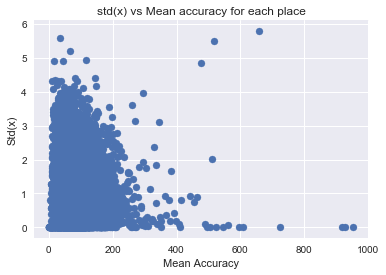

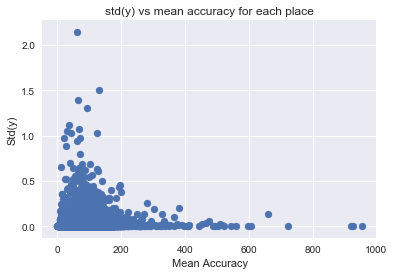

In [5]:
p = plt.scatter(acc_df.mean_accuracy,acc_df.std_x)
plt.xlabel('Mean Accuracy')
plt.ylabel('Std(x)')
plt.title('std(x) vs Mean accuracy for each place')
plt.figure()

p = plt.scatter(acc_df.mean_accuracy, acc_df.std_y)
plt.xlabel('Mean Accuracy')
plt.ylabel('Std(y)')
plt.title('std(y) vs mean accuracy for each place')
plt.show()

### Rectify the accuracy skew by rotating coordinates
* Notice that a 45 degree rotation makes the standard deviations very similar

In [6]:
# rotate x, y by 45 degrees
w = np.pi/4
_df = df.copy()
_df['x'] = df['x']*np.cos(w) - df['y']*np.sin(w)
_df['y'] = df['x']*np.sin(w) + df['y']*np.cos(w)

_acc_df = make_acc_df(_df)
_acc_df.mean()

mean_accuracy    82.279923
std_x             0.480627
std_y             0.480716
dtype: float64

### Standard Deviation of coordinate vs. Accuracy (after rotation)
* Notice the x, y graphs are more similar now

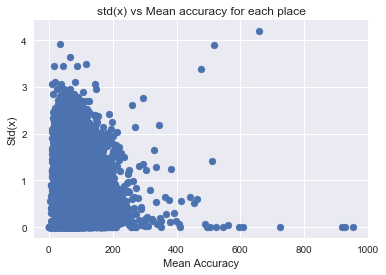

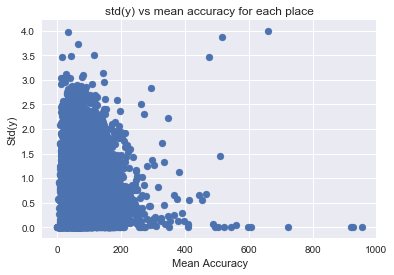

In [7]:
p = plt.scatter(_acc_df.mean_accuracy,_acc_df.std_x)
plt.xlabel('Mean Accuracy')
plt.ylabel('Std(x)')
plt.title('std(x) vs Mean accuracy for each place')
plt.figure()

p = plt.scatter(_acc_df.mean_accuracy, _acc_df.std_y)
plt.xlabel('Mean Accuracy')
plt.ylabel('Std(y)')
plt.title('std(y) vs mean accuracy for each place')
plt.show()

### Plot the mean accuracy vs. coordinate deviation
* Interestingly there is a sweet spot between 50-150 accuracy where the standard deviation (y coordinate in this case) is pretty consistent

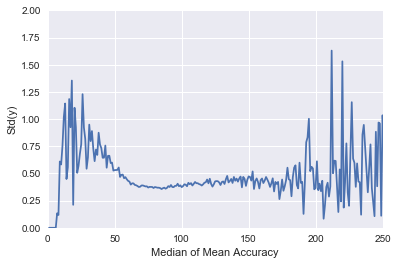

In [8]:
_acc_df['mean_accuracy'] = _acc_df.mean_accuracy.apply(int)
fig = plt.figure()
ax = fig.add_subplot(111)
ax = _acc_df.groupby('mean_accuracy').median().std_y.plot(ax=ax)
ax.set_xlim([0,250])
ax.set_ylim([0,2])
plt.xlabel('Median of Mean Accuracy')
plt.ylabel('Std(y)')

### Fit a curve to the above
* Not sure where I was going with this, might be useful to create a candidate distribution to sample from

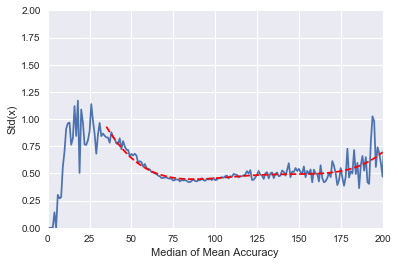

In [11]:
s = _acc_df.groupby('mean_accuracy').mean().std_x
_s = s.loc[35:200]
z = np.polyfit(_s.index, _s, 4)
p = np.poly1d(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(s.index, s, '-', _s.index, p(_s.index), 'r--')
ax.set_xlim([0,200])
ax.set_ylim([0,2])
plt.xlabel('Median of Mean Accuracy')
plt.ylabel('Std(x)')